In [1]:
import numpy as np
import matplotlib.pyplot as plt

from gym_microrts import microrts_ai
from gym_microrts.envs.vec_env import MicroRTSGridModeVecEnv

In [33]:
map_size = 4
envs = MicroRTSGridModeVecEnv(
    num_selfplay_envs=0,
    num_bot_envs=1,
    max_steps=2000,
    render_theme=2,
    ai2s=[microrts_ai.coacAI for _ in range(1)],
    #ai2s=[microrts_ai.vulcanMCTSAI for _ in range(1)],
    map_paths=["maps/4x4/base4x4.xml"],
    reward_weight=np.array([10.0, 1.0, 1.0, 0.2, 1.0, 4.0]),
)
_ = envs.reset()

#### For i in range 1000

In [12]:
action_mask = envs.get_action_mask()
action_mask = action_mask.reshape(-1, action_mask.shape[-1])
action_mask.shape

(16, 78)

In [13]:
action_mask_tiles = action_mask.reshape(map_size, map_size, -1)
action_mask_tiles.shape

(4, 4, 78)

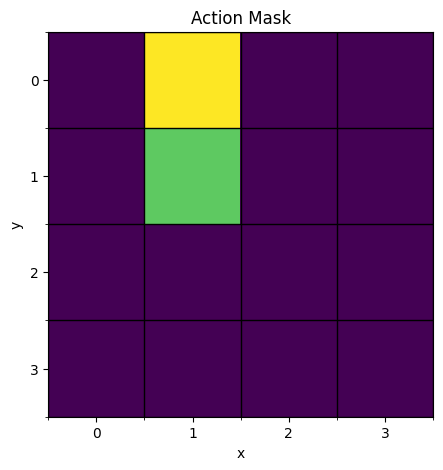

In [14]:
plt.figure(figsize=(5, 5))
plt.imshow(action_mask_tiles.sum(-1))

plt.gca().set_xticks(np.arange(-.5, map_size, 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, map_size, 1), minor=True)
plt.grid(which="minor", axis="both", linestyle="-", color="k", linewidth=1)

plt.xticks(np.arange(0, map_size, 1))
plt.yticks(np.arange(0, map_size, 1))
plt.xlabel("x")
plt.ylabel("y")

plt.title("Action Mask")
plt.show()

In [15]:
def print_action_space(action_mask_tile):
    # (action_mask[0:6]),  # action type: {NOOP, move, harvest, return, produce, attack}
    # (action_mask[6:10]),  # move parameter: {north, east, south, west}
    # (action_mask[10:14]),  # harvest parameter: {north, east, south, west}
    # (action_mask[14:18]),  # return parameter: {north, east, south, west}
    # (action_mask[18:22]),  # produce_direction parameter: {north, east, south, west}
    # (action_mask[22:29]),  # produce_unit_type parameter: {resource, base, barracks, worker, light, heavy, ranged}
    # (action_mask[29 : sum(envs.action_space.nvec[1:])]),  # attack_target parameter: relative position of the unit that will be attacked

    # visualization of the action space for a given tile, translating where 1 means that the corresponding action is available
    
    action_types = ["NOOP", "move", "harvest", "return", "produce", "attack"]

    print("Action Type:")
    mask = action_mask_tile[0:6]
    print_masked(mask, mask)
    print_masked(mask, action_types)
    print()

    location_parameters = ["north", "east", "south", "west"]

    print("Move Parameter:")
    mask = action_mask_tile[6:10]
    print_masked(mask, mask)
    print_masked(mask, location_parameters)
    print()

    print("Harvest Parameter:")
    mask = action_mask_tile[10:14]
    print_masked(mask, mask)
    print_masked(mask, location_parameters)
    print()

    print("Return Parameter:")
    mask = action_mask_tile[14:18]
    print_masked(mask, mask)
    print_masked(mask, location_parameters)
    print()

    print("Produce Direction Parameter:")
    mask = action_mask_tile[18:22]
    print_masked(mask, mask)
    print_masked(mask, location_parameters)
    print()

    unit_types = ["resource", "base", "barracks", "worker", "light", "heavy", "ranged"]

    print("Produce Unit Type Parameter:")
    mask = action_mask_tile[22:29]
    print_masked(mask, mask)
    print_masked(mask, unit_types)
    print()

    print("Attack Target Parameter:")
    mask = action_mask_tile[29:sum(envs.action_space.nvec[1:])]
    print(mask.reshape(7, 7))
    print()


def print_masked(mask, params):
    for i, param in enumerate(params):
        if mask[i] == 1:
            print(f"\033[1m{param: ^7}\033[0m", end=" ")
        else:
            print(f'{param: ^7}', end=" ")
    print()


print_action_space(action_mask_tiles[2][1])
    

Action Type:
   0       0       0       0       0       0    
 NOOP    move   harvest return  produce attack  

Move Parameter:
   0       0       0       0    
 north   east    south   west   

Harvest Parameter:
   0       0       0       0    
 north   east    south   west   

Return Parameter:
   0       0       0       0    
 north   east    south   west   

Produce Direction Parameter:
   0       0       0       0    
 north   east    south   west   

Produce Unit Type Parameter:
   0       0       0       0       0       0       0    
resource  base   barracks worker   light   heavy  ranged  

Attack Target Parameter:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]



In [16]:
[
    [1, 0, 0, 0, 0, 0],  # action type: {NOOP, move, harvest, return, produce, attack}
    [0, 0, 0, 0],  # move parameter: {north, east, south, west}
    [0, 0, 0, 0],  # harvest parameter: {north, east, south, west}
    [0, 0, 0, 0],  # return parameter: {north, east, south, west}
    [0, 0, 0, 0],  # produce_direction parameter: {north, east, south, west}
    [0, 0, 0, 0, 0, 0, 0],  # produce_unit_type parameter: {resource, base, barracks, worker, light, heavy, ranged}
    np.zeros(sum(envs.action_space.nvec[1:]))  # attack_target parameter: relative position of the unit that will be attacked
]

[[1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 array([0., 0., 0., ..., 0., 0., 0.])]

In [34]:
ac_move_east = np.array([
    1,  # action type: {NOOP, move, harvest, return, produce, attack}
    2,  # move parameter: {north, east, south, west}
    0,  # harvest parameter: {north, east, south, west}
    0,  # return parameter: {north, east, south, west}
    0,  # produce_direction parameter: {north, east, south, west}
    0,  # produce_unit_type parameter: {resource, base, barracks, worker, light, heavy, ranged}
    0  # attack_target parameter: relative position of the unit that will be attacked
])
ac_produce_worker_south = np.array([4, 0, 0, 0, 2, 3, 0])

In [38]:
action = np.zeros((map_size, map_size, 7))
action.shape

(4, 4, 7)

In [39]:
action[1][0] = ac_move_east
action[1][1] = ac_produce_worker_south

In [40]:
action[1][1]

array([4., 0., 0., 0., 2., 3., 0.])

In [41]:
_ = envs.reset()

In [42]:
for i in range(50):
    response = envs.step(
        action
    )

    img = envs.render(mode='rgb_array')
    plt.imshow(img)

    if response[2][0]:
        print("done")
        break

AttributeError: 'MicroRTSGridModeVecEnv' object has no attribute 'source_unit_mask'

In [163]:
action 

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       ...,

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1.

In [132]:
action_mask = envs.get_action_mask()
action_mask = action_mask.reshape(-1, action_mask.shape[-1])

In [133]:
action_mask.shape

(256, 78)